In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import xlsxwriter
import pandas as pd # Excel
import struct # Binary writing
import h5py
import time

import scipy.signal
import scipy.ndimage
import scipy.io as sio # Read .mat files
from scipy.ndimage.filters import convolve,correlate,median_filter
import sklearn.metrics as skmet
import sklearn.decomposition as skdec
import sklearn.linear_model as sklin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import neighbors

In [36]:
#Regression
def regress(features,score):
    pred = []
    #Leave one out split
    loo = LeaveOneOut()	
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        X_test -= X_train.mean(0)
        X_train -= X_train.mean(0)

        Y_train, Y_test = score[trainidx], score[testidx]		
        #Linear regression		
        regr = sklin.Ridge(alpha=1)
        regr.fit(X_train,Y_train)
        #Predicted score		
        pred.append(regr.predict(X_test))

    return np.array(pred)

#Logistic regression
def logreg(features,score):
    pred = []
    #Leave one out split
    loo = LeaveOneOut()	
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        X_test -= X_train.mean(0)
        X_train -= X_train.mean(0)

        Y_train, Y_test = score[trainidx], score[testidx]		
        #Linear regression
        regr = sklin.LogisticRegression(solver='newton-cg',max_iter=1000)
        regr.fit(X_train,Y_train)
        #Predicted score
        P = regr.predict_proba(X_test)
        pred.append(P)

    pred = np.array(pred)
    pred = pred[:,:,1]
    return pred.flatten()

#Scikit PCA
def ScikitPCA(features,ncomp):
    pca = skdec.PCA(n_components=ncomp, svd_solver='full')
    score = pca.fit(features).transform(features)
    return pca, score

#Principal component analysis
def PCA(features,ncomp):	
    #Feature dimension, x=num variables,N=num observations
    x,N = np.shape(features)
    #Mean feature
    mean_f = np.mean(features,axis=1)
    #Centering
    centrd = np.zeros((x,N))
    for k in range(N):
        centrd[:,k] = features[:,k]-mean_f

    #PCs from covariance matrix if N>=x, svd otherwise
    if False:
        #Covariance matrix
        Cov = np.zeros((x,x))
        f = np.zeros((x,1))
        for k in range(N):		
            f[:,0] = centrd[:,k]
            Cov = Cov+1/N*np.matmul(f,f.T)

        #Eigen values
        E,V = np.linalg.eig(Cov)		
        #Sort eigenvalues and vectors to descending order
        idx = np.argsort(E)[::-1]
        V = np.matrix(V[:,idx])
        E = E[idx]

        for k in range(ncomp):						
            s = np.matmul(V[:,k].T,centrd).T			
            try:
                score = np.concatenate((score,s),axis=1)
            except NameError:
                score = s
            p = V[:,k]
            try:
                pcomp = np.concatenate((pcomp,p),axis=1)
            except NameError:
                pcomp = p
    else:
        #PCA with SVD
        u,s,v = np.linalg.svd(centrd,compute_uv=1)
        pcomp = v[:,:ncomp]
        # Save results
        writer = pd.ExcelWriter(r'C:\Users\sarytky\Desktop\trials' + r'\PCA_test.xlsx')
        df1 = pd.DataFrame(centrd)
        df1.to_excel(writer, sheet_name='dataAdjust')
        df2 = pd.DataFrame(u)
        df2.to_excel(writer, sheet_name='u')
        df3 = pd.DataFrame(s)
        df3.to_excel(writer, sheet_name='s')
        df4 = pd.DataFrame(v)
        df4.to_excel(writer, sheet_name='v')        
        writer.save()
        np.savetxt(r'C:\Users\sarytky\Desktop\trials' + '\\''dataAdjust_python.csv', centrd, delimiter=',')

        score = np.matmul(u,s).T[:,1:ncomp]
    return pcomp,score

#Local grayscale standardization
def localstandard(im,w1,w2,sigma1,sigma2):
    #Centers grayscales with Gaussian weighted mean
    #Gaussian kernels
    kernel1 = Gauss2D(w1,sigma1)
    kernel2 = Gauss2D(w2,sigma2)
    #Blurring
    blurred1 = scipy.ndimage.convolve(im,kernel1)
    blurred2 = scipy.ndimage.convolve(im,kernel2)
    #print(blurred1[11,:])
    #Centering grayscale values
    centered = im-blurred1
    #Standardization
    std = (scipy.ndimage.convolve(centered**2,kernel2))**0.5
    new_im = centered/(std+1e-09)
    return new_im

#Gaussian kernel
def Gauss2D(w,sigma):
    #Generates 2d gaussian kernel
    kernel = np.zeros((w,w))
    #Constant for centering
    r = (w-1)/2
    for ii in range(w):
        for jj in range(w):
            x = -((ii-r)**2+(jj-r)**2)/(2*sigma**2)
            kernel[ii,jj] = np.exp(x)
    #Normalizing the kernel
    kernel = 1/np.sum(kernel)*kernel
    return kernel

def bnw(x,y):
    #Rounding
    x1 = np.floor(x)
    x2 = np.ceil(x)
    
    y1 = np.floor(y)
    y2 = np.ceil(y)
    
    #Compute weights
    if x2-x1 != 0:
        w11 = (x2-x)/(x2-x1)
        w12 = (x-x1)/(x2-x1)
        w21 = (x2-x)/(x2-x1)
        w22 = (x-x1)/(x2-x1)
    else:
        w11 = 1
        w12 = 1
        w21 = 1
        w22 = 1
        
    if y2-y1 != 0:
        w11 *= (y2-y)/(y2-y1)
        w12 *= (y2-y)/(y2-y1)
        w21 *= (y-y1)/(y2-y1)
        w22 *= (y-y1)/(y2-y1)
    else:
        w11 *= 1
        w12 *= 1
        w21 *= 1
        w22 *= 1
    
    return w11,w12,w21,w22

def LBP(I,N,R):
    ks = 2*(R+1)+1
    c = R+1
    kernel = np.zeros((ks,ks))
    filterbank = []
    theta = np.linspace(0,N-1,N)
    theta *= 2*np.pi/N
    for k in range(N):
        
        #Set center to -1
        _krnl = kernel.copy()
        
        #Compute neighbour coordinates
        x = R*np.cos(theta[k])
        y = R*np.sin(theta[k])
                
        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))
        y1 = int(np.floor(y))
        y2 = int(np.ceil(y))
        
        
        #Compute interpolation weights
        w11,w12,w21,w22 = bnw(x,y)
        
        #Insert weights to kernel
        _krnl[c+y1,c+x1] = w11
        _krnl[c+y1,c+x2] = w12
        _krnl[c+y2,c+x1] = w21
        _krnl[c+y2,c+x2] = w22
                
        #Append kernel to list
        filterbank.append(_krnl)
        
    #Compute lbp
    lbp = []
    for k in range(len(filterbank)):
        _lbp = correlate(I,filterbank[k])-I
        _lbp = _lbp
        _lbp = (_lbp>=1e-6)*1.0
        lbp.append(_lbp)
        
    #LBP to numpy array, channels to 3rd axis
    lbp = np.array(lbp)
    lbp = np.swapaxes(lbp,0,2)
    
    lbpI = np.zeros(lbp[:,:,0].shape)
    for k in range(lbp.shape[2]):
        lbpI += lbp[:,:,k]*2**(lbp[:,:,k]*k)
    
    return lbp,lbpI

def MRELBP(I,N,R,r,wc,wR,wr, mode='hist'):
    print(np.shape(I))
    #Mean grayscale value and std
    muI = I.mean()
    stdI = I.std()

    #Centering and scaling with std
    I = (I-muI)/stdI
    
    Ic = median_filter(I,wc)
    IR = median_filter(I,wR)
    Ir = median_filter(I,wr)

    
    print(np.shape(I))
    #kernel weigths
    f1 = []
    f2 = []
    
    ks = 2*(R+1)+1
    c = R+1
    kernel = np.zeros((ks,ks))
    theta = np.linspace(0,N-1,N)
    theta *= 2*np.pi/N
    
    #Kernels
    for k in range(N):
        #Large radius
        _krnl = kernel.copy()
        
        #Compute neighbour coordinates
        x = R*np.cos(theta[k])
        y = R*np.sin(theta[k])
                
        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))
        y1 = int(np.floor(y))
        y2 = int(np.ceil(y))
        
        #Compute interpolation weights
        w11,w12,w21,w22 = bnw(x,y)
        
        #Insert weights to kernel
        _krnl[c+y1,c+x1] = w11
        _krnl[c+y1,c+x2] = w12
        _krnl[c+y2,c+x1] = w21
        _krnl[c+y2,c+x2] = w22
                
        #Append kernel to list
        f1.append(_krnl)
        
        #Small radius
        _krnl = kernel.copy()
        
        #Compute neighbour coordinates
        x = r*np.cos(theta[k])
        y = r*np.sin(theta[k])
                
        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))
        y1 = int(np.floor(y))
        y2 = int(np.ceil(y))
        
        #Compute interpolation weights
        w11,w12,w21,w22 = bnw(x,y)
        
        #Insert weights to kernel
        _krnl[c+y1,c+x1] = w11
        _krnl[c+y1,c+x2] = w12
        _krnl[c+y2,c+x1] = w21
        _krnl[c+y2,c+x2] = w22
                
        #Append kernel to list
        f2.append(_krnl)
    #Compute lbps
    lbpR = []
    lbpr = []
    lbpD = []
    
    for k in range(len(f1)):
        _lbpR = correlate(I,f1[k])-Ic
        _lbpR = (_lbpR>=1e-6)*1.0
        lbpR.append(_lbpR)
        _lbpr = correlate(I,f2[k])-Ic
        _lbpr = (_lbpr>=1e-6)*1.0
        lbpr.append(_lbpr)
        _lbpD = _lbpR-_lbpr
        _lbpD = (_lbpD>=1e-6)*1.0
        lbpD.append(_lbpD)
        
    #LBP to numpy array, channels to 3rd axis
    lbpR = np.array(lbpR)
    lbpR = np.swapaxes(lbpR,0,2)
    
    lbpr = np.array(lbpR)
    lbpr = np.swapaxes(lbpR,0,2)
    
    lbpD = np.array(lbpD)
    lbpD = np.swapaxes(lbpD,0,2)
    
    lbpIR = np.zeros(lbpR[:,:,0].shape)
    lbpIr = np.zeros(lbpr[:,:,0].shape)
    lbpID = np.zeros(lbpD[:,:,0].shape)
    print(np.shape(lbpIR))
    for k in range(lbpR.shape[2]):
        lbpIR += lbpR[:,:,k]*2**k
        lbpIr += lbpr[:,:,k]*2**k
        lbpID += lbpD[:,:,k]*2**k
        
    #histograms
    #Center pixels
    d = round(R+(wR-1)/2)
    lbpIR = lbpIR[d:-d,d:-d]
    d1 = round((wr-1)/2)
    lbpIr = lbpIr[d1:-d1,d1:-d1]
    d2 = round((wR-1)/2)
    lbpID = lbpID[d2:-d2,d2:-d2]
    
    histR = np.zeros((2**N,1))
    histr = np.zeros((2**N,1))
    histD = np.zeros((2**N,1))
    
    for k in range(2**N):
        _tmp = (lbpIR==k)*1.0
        histR[k] += _tmp.sum()
        _tmp = (lbpIr==k)*1.0
        histr[k] += _tmp.sum()
        _tmp = (lbpID==k)*1.0
        histD[k] += _tmp.sum()
    
    lbpc = (Ic-Ic.mean())>=1e-6
    d = round(R+(wc-1)/2)
    lbpc = lbpc[d:-d,d:-d]
    
    histc = np.zeros((2,1))
    histc[0,0] = np.sum((lbpc==0)*1.0)
    histc[1,0] = np.sum((lbpc==1)*1.0)
    
    if mode == 'hist':
        return histc,histR,histr,histD
    else:
        return lbpc,lbpIR,lbpIr,lbpID
    
    #Mapping
def getmapping(N):
    #Defines rotation invariant uniform mapping for lbp of N neighbours	
    newMax = N + 2
    table = np.zeros((1,2**N))
    for k in range(2**N):
        #Binary representation of bin number
        binrep = np.binary_repr(k,N)
        #Convert string to list of digits
        i_bin = np.zeros((1,len(binrep)))
        for ii in range(len(binrep)):
            i_bin[0,ii] = int(float(binrep[ii]))
        #Rotation
        j_bin = np.roll(i_bin,-1)
        #uniformity
        numt = np.sum(i_bin!=j_bin)
        #Binning
        if numt <= 2:
            b = np.binary_repr(k,N)
            c=0
            for ii in range(len(b)):
                c = c+int(float(b[ii]))
            table[0,k] = c
        else:
            table[0,k] = N+1
    #num = newMax
    return table

#Apply mapping to lbp
def maplbp(bin,mapping):
    #Applies mapping to lbp bin
    #Number of bins in output
    N = int(np.max(mapping))
    #Empty array
    outbin = np.zeros((1,N+1))
    for k in range(N+1):
        #RIU indices
        M = mapping==k
        #Extract indices from original bin to new bin
        outbin[0,k] = np.sum(M*bin)
    return outbin

def loadbinary(path):
    bytesarray = np.fromfile(path, dtype=np.int32) # read everything as int32
    w = bytesarray[0]
    l = int((bytesarray.size - 1) / w)
    with open(path, "rb") as f: # open to read binary file
        f.seek(4) # skip first integer (width)
        features = np.zeros((w,l))
        for i in range(w):
            for j in range(l):
                features[i, j] = struct.unpack('<i', f.read(4))[0]  # when reading byte by byte (struct), 
                                                                #data type can be defined with every byte
        return features

def writebinaryweights(path, ncomp, eigenvectors, singularvalues, weights):
    with open(path, "wb") as f:
        f.write(struct.pack('<i', eigenvectors.shape[1])) # Width
        f.write(struct.pack('<i', ncomp)) # Number of components
        # Eigenvectors 
        for i in range(eigenvectors.shape[0]):
            for j in range(eigenvectors.shape[1]):
                f.write(struct.pack('<f', eigenvectors[i, j]))
        # Singular values
        for i in range(singularvalues.shape[0]):
            f.write(struct.pack('<f', singularvalues[i]))
        # Weights
        for i in range(weights.shape[0]):
            f.write(struct.pack('<f', weights[i]))            
    return True

def writebinaryimage(path, image, dtype):
    with open(path, "wb") as f:
        f.write(struct.pack('<i', image.shape[0])) # Width
        # Image values as float
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if dtype == 'float':
                    f.write(struct.pack('<f', image[i, j]))
                if dtype == 'double':
                    f.write(struct.pack('<d', image[i, j]))
                if dtype == 'int':
                    f.write(struct.pack('<i', image[i, j]))                    
    return True

Processing: 13_R3L_topo.mat


RuntimeError: Can't decrement id ref count (file write failed: time = Tue Sep  4 09:41:16 2018
, filename = 'V:\Tuomas\PTASurfaceImages\O19_L6L_topo.mat', file descriptor = 7, errno = 22, error message = 'Invalid argument', buf = 000001937F6EF348, total write size = 96, bytes this sub-write = 96, bytes actually written = 18446744073709551615, offset = 512)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 193, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue Sep  4 09:41:16 2018
, filename = 'V:\Tuomas\PTASurfaceImages\O19_L6L_topo.mat', file descriptor = 7, errno = 22, error message = 'Invalid argument', buf = 000001937F6EF348, total write size = 96, bytes this sub-write = 96, bytes actually written = 18446744073709551615, offset = 512)


(400, 400)
(400, 400)
(400, 400)
[[66085. 76799.]]
[[  142884.  1143072.  1143072.  1143072.  1143072.  1143072.  1143072.
   1143072.   142884. 28291032.]]
[[  1584.  12672.  12672.  12672.  12672.  12672.  12672.  12672.   1584.
  313632.]]
[[  156816.  1254528.  1254528.  1254528.  1254528.  1254528.  1254528.
   1254528.   156816. 31049568.]]
Processing: 13_R6TL_topo.mat
(400, 400)
(400, 400)
(400, 400)
[[66846. 76038.]]
[[  142884.  1143072.  1143072.  1143072.  1143072.  1143072.  1143072.
   1143072.   142884. 28291032.]]
[[  1584.  12672.  12672.  12672.  12672.  12672.  12672.  12672.   1584.
  313632.]]
[[  156816.  1254528.  1254528.  1254528.  1254528.  1254528.  1254528.
   1254528.   156816. 31049568.]]
Processing: 14_R3L_topo.mat
(400, 400)
(400, 400)
(400, 400)
[[68921. 73963.]]
[[  142884.  1143072.  1143072.  1143072.  1143072.  1143072.  1143072.
   1143072.   142884. 28291032.]]
[[  1584.  12672.  12672.  12672.  12672.  12672.  12672.  12672.   1584.
  313632.]]
[[

(400, 400)
(400, 400)
(400, 400)
[[70522. 72362.]]
[[  142884.  1143072.  1143072.  1143072.  1143072.  1143072.  1143072.
   1143072.   142884. 28291032.]]
[[  1584.  12672.  12672.  12672.  12672.  12672.  12672.  12672.   1584.
  313632.]]
[[  156816.  1254528.  1254528.  1254528.  1254528.  1254528.  1254528.
   1254528.   156816. 31049568.]]
Processing: 28_L6MT_topo.mat
(400, 400)
(400, 400)
(400, 400)
[[67654. 75230.]]
[[  142884.  1143072.  1143072.  1143072.  1143072.  1143072.  1143072.
   1143072.   142884. 28291032.]]
[[  1584.  12672.  12672.  12672.  12672.  12672.  12672.  12672.   1584.
  313632.]]
[[  156816.  1254528.  1254528.  1254528.  1254528.  1254528.  1254528.
   1254528.   156816. 31049568.]]
Processing: 29_R2M_topo.mat
(400, 400)
(400, 400)
(400, 400)
[[66238. 76646.]]
[[  142884.  1143072.  1143072.  1143072.  1143072.  1143072.  1143072.
   1143072.   142884. 28291032.]]
[[  1584.  12672.  12672.  12672.  12672.  12672.  12672.  12672.   1584.
  313632.]]
[[

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Confusion matrix
[[0 7 1 0]
 [0 8 3 0]
 [0 6 7 0]
 [1 0 3 0]]
Mean squared error, Area under curve
0.9059561232449312 0.6250000000000001
-- 61.844966650009155 seconds --
R2 score
-0.009560735791428243
Sample, grade, prediction
13_R3L_topo.mat 2 [1.87079366]
13_R6TL_topo.mat 2 [1.76304649]
14_R3L_topo.mat 0 [1.54777787]
14_R6LT_topo.mat 1 [1.01533265]
15_L3L_topo.mat 2 [1.05381541]
15_L6TL_topo.mat 3 [1.62103777]
20_R2M_topo.mat 2 [1.17378743]
20_R6TM_topo.mat 2 [1.60200468]
21_L3L_topo.mat 0 [1.05136625]
21_L6LT_topo.mat 2 [1.42105045]
22_L3L_topo.mat 1 [1.39594136]
22_L6TL_topo.mat 1 [1.03092616]
23_R3L_topo.mat 1 [1.17680853]
23_R6LT_topo.mat 3 [0.24868771]
24_R3L_topo.mat 2 [1.09061606]
24_R6LT_topo.mat 2 [1.76986118]
25_L3L_topo.mat 1 [1.62292064]
25_L6TL_topo.mat 3 [1.59846942]
26_L3L_topo.mat 2 [1.83875052]
26_L6LT_topo.mat 1 [1.40492278]
27R3M_topo.mat 1 [1.61024265]
27R6T_topo.mat 2 [1.96163415]
28_L3L_topo.mat 0 [1.31935622]
28_L6MT_topo.mat 1 [1.70536181]
29_R2M_topo.mat 3 [1

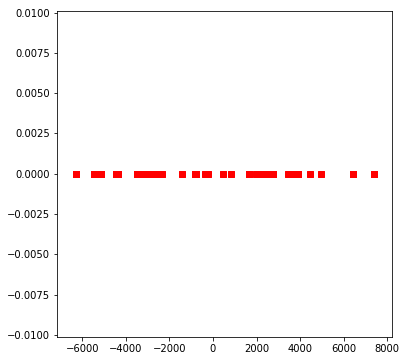

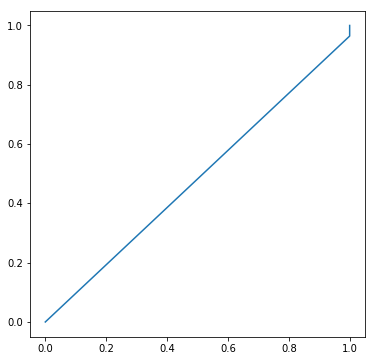

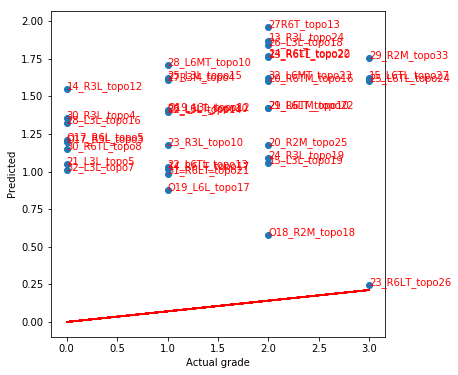

In [37]:
#Start time
start_time = time.time()

#Samples
impath = r'V:\Tuomas\PTASurfaceImages'
path = r'C:\Users\sarytky\Desktop\trials'
filelist = os.listdir(impath)
filelist.sort()

# Load grades to array
grades = pd.read_excel(r'C:\Users\sarytky\Desktop\trials' + r'\PTAgreiditjanaytteet.xls', 'Sheet1')
grades = pd.DataFrame(grades).values
g = grades[:,2].astype('int')
grades = grades[:,1:2]

# Features
dict = {'N':8, 'R':9,'r':3,'wc':5,'wr':(5,5)}
mapping = getmapping(dict['N']) # mapping
files = os.listdir(impath)
files.sort()
filelist = files
features = None # Reset feature array

for k in range(len(files)):
    #Load file
    print('Processing: ' + files[k])
    file = os.path.join(impath,files[k])
    try:
        file = sio.loadmat(file)
        Mz = file['Mz']
        sz = file['sz']
    except NotImplementedError:
        file = h5py.File(file)
        Mz = file['Mz'][()]
        sz = file['sz'][()]
    #Combine mean and sd images
    image = Mz+sz
    #Grayscale normalization
    image = localstandard(image,23,5,5,1)
    # LBP
    Chist,Lhist,Shist,Rhist = MRELBP(image,dict['N'],dict['R'],dict['r'],dict['wc'],dict['wr'][0],dict['wr'][1] , mode = 'hist')
    f1 = Chist.T
    f2 = maplbp(Lhist,mapping)
    f3 = maplbp(Shist,mapping)
    f4 = maplbp(Rhist,mapping)
    #Concatenate features
    #print(np.shape(f1))
    #print(np.shape(f2))
    #print(np.shape(f3))
    #print(np.shape(f4))
    print(f1)
    print(f2)
    print(f3)
    print(f4)
    f = np.concatenate((f1.T,f2.T,f3.T,f4.T),axis=0)
    try:
        features = np.concatenate((features,f),axis=1)
    except ValueError:
        features = f

# Save features
writer = pd.ExcelWriter(path + r'\LBP_features_conv.xlsx')
df1 = pd.DataFrame(features)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()

#PCA
pca, score = ScikitPCA(features.T,10)
#pca, score = PCA(features,10)
print(score[0,:])

# Regression
pred1 = regress(score,g)
pred2 = logreg(score,g>0)
for p in range(len(pred1)):
    if pred1[p]<0:
        pred1[p] = 0
    if pred1[p] > 3:
        pred1[p]=3

#Plotting the prediction
a = g
b = np.round(pred1).astype('int')	

#Plotting
x = score[:,0]
y = score[:,1]
fig = plt.figure(figsize=(6,6))
#plt.grid(True)
ax1 = fig.add_subplot(111)
ax1.scatter(score[g<2,0],score[g<2,1],marker='o',color='b',label='Normal')	
ax1.scatter(score[g>1,0],score[g>1,1],marker='s',color='r',label='OA')

for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])		
    if grades[k,0] >= 2:
        ax1.scatter(x[k],y[k],marker='s',color='r')
        #ax1.annotate(txt,xy=(x[k],y[k]),color='r')
    else:
        ax1.scatter(x[k],y[k],marker='o',color='b')
        #ax1.annotate(txt,xy=(x[k],y[k]),color='b')	

C1 = skmet.confusion_matrix(a,b)
MSE1 = skmet.mean_squared_error(a,pred1)
fpr, tpr, thresholds = skmet.roc_curve(a>0, np.round(pred1)>0, pos_label=1)
AUC1 = skmet.auc(fpr,tpr)
AUC1 = skmet.roc_auc_score(a>0,pred2)
t = time.time()-start_time
m, b = np.polyfit(a, pred1.flatten(), 1)
R2 = skmet.r2_score(a,pred1.flatten())
fig0  = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111)
ax0.plot(fpr,tpr)

print('Confusion matrix')
print(C1)
print('Mean squared error, Area under curve')
print(MSE1,AUC1)#,MSE2,MSE3,MSE4)
print("-- %s seconds --" % t)
print('R2 score')
print(R2)
print('Sample, grade, prediction')
for k in range(len(filelist)):
    print(filelist[k],a[k],pred1[k])#,pred3[k])
    
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
ax2.scatter(a,pred1.flatten())
ax2.plot(a,m*a,'-',color='r')
ax2.set_xlabel('Actual grade')
ax2.set_ylabel('Predicted')
for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])
    ax2.annotate(txt,xy=(a[k],pred1[k]),color='r')
plt.show()